<a href="https://colab.research.google.com/github/CamiSilvae/PDI/blob/main/ClaseOrdinaria/ExamenOrd/Ejercicio1/ORD_EJ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXAMEN ORDINARIO

Camila Andrea Silva Espinoza (2109522)

---

**EJERCICIO 1: Restauración avanzada en frecuencia**

1. Carga de librerias y de imagen

En esta celda importamos las librerías necesarias y subimos la imagen usando files.upload(). La imagen se carga en escala de grises y se normaliza entre 0 y 1.

Saving Ejercicio1.jpg to Ejercicio1.jpg


(np.float64(-0.5), np.float64(377.5), np.float64(281.5), np.float64(-0.5))

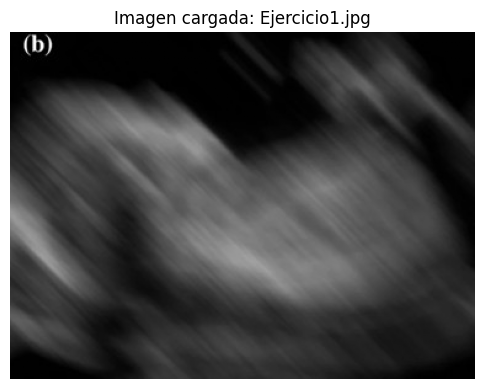

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab import files
import math
import pandas as pd

uploaded = files.upload()
image_name = list(uploaded.keys())[0]

img = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError(f"No se pudo leer la imagen {image_name}. Asegúrate del formato.")

img = img.astype(np.float32) / 255.0

plt.figure(figsize=(6,6))
plt.title(f"Imagen cargada: {image_name}")
plt.imshow(img, cmap='gray')
plt.axis('off')


2. Obtención de FFT, magnitud y fase

En esta celda realizamos la Transformada Rápida de Fourier (FFT) y analizamos sus componentes fundamentales: la magnitud y la fase. La FFT nos permite representar la imagen en el dominio de la frecuencia, donde la magnitud describe la energía asociada a cada frecuencia y la fase contiene información sobre la estructura y localización espacial.

Aplicamos FFT 2D, centramos el espectro con `fftshift`, y mostramos gráficamente la magnitud (en escala logarítmica para resaltar detalles) y la fase. Esta información será esencial para entender el efecto del filtrado en frecuencia y la importancia de la fase durante la restauración.

(np.float64(-0.5), np.float64(377.5), np.float64(281.5), np.float64(-0.5))

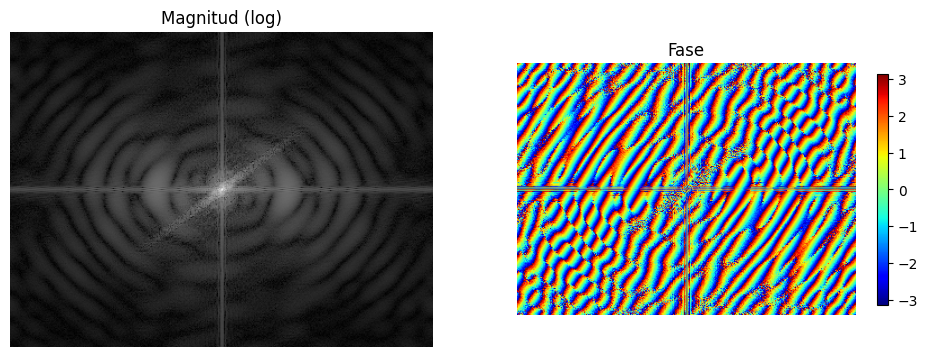

In [2]:
def compute_fft(image):
    F = np.fft.fft2(image)
    F_shift = np.fft.fftshift(F)
    magnitude = np.log1p(np.abs(F_shift))
    phase = np.angle(F_shift)
    return F, F_shift, magnitude, phase

F, F_shift, magnitude, phase = compute_fft(img)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Magnitud (log)')
plt.imshow(magnitude, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Fase')
plt.imshow(phase, cmap='jet')
plt.colorbar(shrink=0.6)
plt.axis('off')


3. b)	Modela una PSF lineal de movimiento (L = 20 px, θ = 15°)

Se encarga de modelar la PSF que simula simula el desenfoque por movimiento. La PSF describe cómo un punto de la escena se desplaza en la dirección y longitud del movimiento, generando trazos en la imagen. Para este ejercicio, el movimiento tiene una longitud de 20 píxeles y un ángulo de 15°, como pide el examen.

El kernel generado posteriormente se inserta en una matriz del tamaño de la imagen para poder aplicarlo con FFT. Esta PSF es la base para generar la imagen degradada y para realizar los filtros de restauración en frecuencia.

(np.float64(-0.5), np.float64(40.5), np.float64(40.5), np.float64(-0.5))

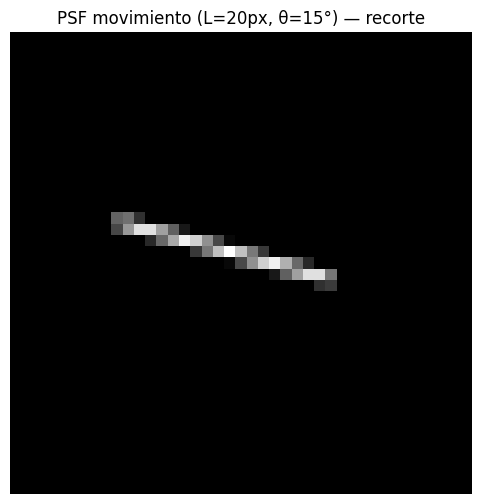

In [3]:
def motion_psf(length, angle_deg, shape):
    length = max(1, int(length))
    angle = np.deg2rad(angle_deg)
    size = length if length % 2 == 1 else length + 1
    kernel = np.zeros((size, size), dtype=np.float32)
    c = size // 2
    kernel[c, :length] = 1.0
    M = cv2.getRotationMatrix2D((c,c), -angle_deg, 1.0)
    kernel = cv2.warpAffine(kernel, M, (size, size), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    kernel_sum = kernel.sum()
    if kernel_sum != 0:
        kernel = kernel / kernel_sum
    out = np.zeros(shape, dtype=np.float32)
    h, w = shape
    ph = (h - size) // 2
    pw = (w - size) // 2
    out[ph:ph+size, pw:pw+size] = kernel
    return out

L = 20
theta = 15
psf = motion_psf(L, theta, img.shape)

h,w = psf.shape
s = max(41, L+10)
ph = max(0, h//2 - s//2)
pw = max(0, w//2 - s//2)
plt.figure(figsize=(6,6))
plt.title(f"PSF movimiento (L={L}px, θ={theta}°) — recorte")
plt.imshow(psf[ph:ph+s, pw:pw+s], cmap='gray')
plt.axis('off')


4. Aplica (Inverso, Inverso generalizado con a = 0.3
y Wiener SNR = 10, 1, 0.1)

Transformamos la PSF al dominio de la frecuencia usando FFT para obtener H(u,v), necesario para aplicar filtros de restauración en frecuencia. Además, definimos las funciones de filtrado:

* Filtro Inverso, que intenta deshacer la degradación de manera directa, aunque suele ser inestable.

* Filtro Inverso Generalizado, que introduce un parámetro de regularización para evitar amplificación excesiva del ruido.

* Filtro de Wiener, que incorpora la relación señal/ruido para equilibrar restauración y supresión del ruido.

Esta celda prepara las herramientas necesarias para restaurar la imagen más adelante.


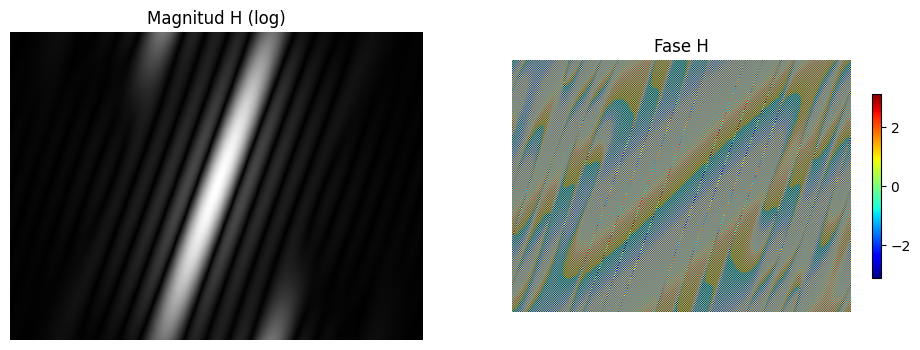

In [4]:
def psf2otf(psf):
    return np.fft.fft2(psf)

H = psf2otf(psf)
H_shift = np.fft.fftshift(H)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('Magnitud H (log)')
plt.imshow(np.log1p(np.abs(H_shift)), cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Fase H')
plt.imshow(np.angle(H_shift), cmap='jet')
plt.colorbar(shrink=0.6)
plt.axis('off')

def inverse_filter(G, H, eps_threshold=1e-3):
    denom = H.copy()
    small = np.abs(denom) < eps_threshold
    denom[small] = eps_threshold
    F_est = G / denom
    return F_est

def generalized_inverse_filter(G, H, a):
    H_conj = np.conj(H)
    denom = (np.abs(H)**2 + a)
    F_est = (H_conj * G) / denom
    return F_est

def wiener_filter(G, H, K):
    H_conj = np.conj(H)
    denom = (np.abs(H)**2 + K)
    F_est = (H_conj * G) / denom
    return F_est


5. Imagen degradada

Aquí generamos la imagen degradada aplicando la PSF al original. La degradación se realiza mediante la convolución en frecuencia, que es computacionalmente eficiente.

Posteriormente, añadimos ruido gaussiano controlado para simular diferentes condiciones de adquisición. Esto es importante para evaluar el desempeño de los filtros, especialmente el filtro de Wiener, que depende del nivel de ruido.

(np.float64(-0.5), np.float64(377.5), np.float64(281.5), np.float64(-0.5))

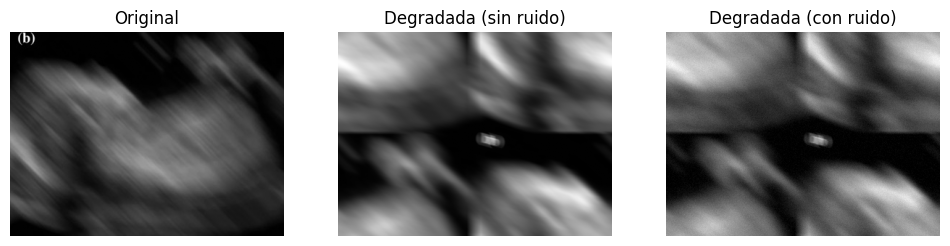

In [5]:
def convolve_freq(image, psf):
    F = np.fft.fft2(image)
    H = np.fft.fft2(psf)
    G = F * H
    g = np.real(np.fft.ifft2(G))
    return g

img_degraded = convolve_freq(img, psf)

add_noise = True
sigma_noise = 0.01
if add_noise:
    noise = np.random.normal(0, sigma_noise, img.shape).astype(np.float32)
    img_degraded_noisy = np.clip(img_degraded + noise, 0.0, 1.0)
else:
    img_degraded_noisy = img_degraded.copy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title('Original'); plt.imshow(img, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title('Degradada (sin ruido)'); plt.imshow(np.clip(img_degraded,0,1), cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('Degradada (con ruido)'); plt.imshow(np.clip(img_degraded_noisy,0,1), cmap='gray'); plt.axis('off')


6. Métodos de restauración

Cada método ataca la degradación de manera distinta:

* El filtro inverso intenta deshacer la PSF directamente, pero es muy sensible al ruido.

* El inverso generalizado mejora la estabilidad agregando regularización.

* El Wiener es el más robusto y toma en cuenta el SNR.

Al final, mostramos todas las reconstrucciones juntas para compararlas visualmente.

(np.float64(-0.5), np.float64(377.5), np.float64(281.5), np.float64(-0.5))

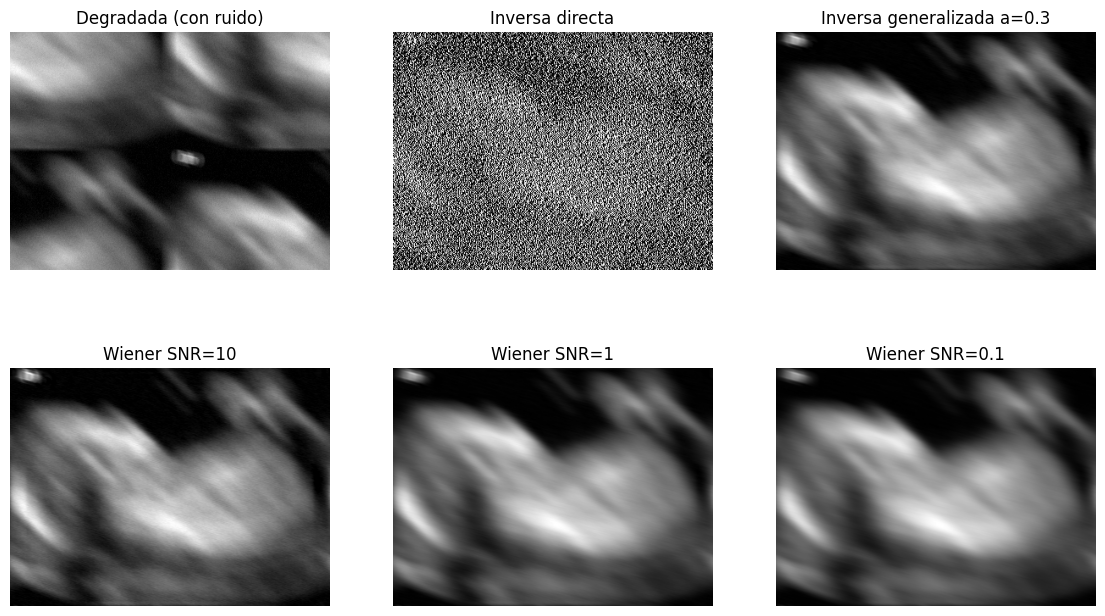

In [6]:
G = np.fft.fft2(img_degraded_noisy)
H = np.fft.fft2(psf)

F_inv = inverse_filter(G, H, eps_threshold=1e-3)
rec_inv = np.real(np.fft.ifft2(F_inv))
rec_inv = np.clip(rec_inv, 0.0, 1.0)

a = 0.3
F_geninv = generalized_inverse_filter(G, H, a)
rec_geninv = np.real(np.fft.ifft2(F_geninv))
rec_geninv = np.clip(rec_geninv, 0.0, 1.0)

snrs = [10, 1, 0.1]
rec_wiener = {}
for s in snrs:
    K = 1.0 / s
    F_w = wiener_filter(G, H, K)
    rec = np.real(np.fft.ifft2(F_w))
    rec = np.clip(rec, 0.0, 1.0)
    rec_wiener[s] = rec

plt.figure(figsize=(14,8))
plt.subplot(2,3,1); plt.title('Degradada (con ruido)'); plt.imshow(img_degraded_noisy, cmap='gray'); plt.axis('off')
plt.subplot(2,3,2); plt.title('Inversa directa'); plt.imshow(rec_inv, cmap='gray'); plt.axis('off')
plt.subplot(2,3,3); plt.title('Inversa generalizada a=0.3'); plt.imshow(rec_geninv, cmap='gray'); plt.axis('off')
plt.subplot(2,3,4); plt.title('Wiener SNR=10'); plt.imshow(rec_wiener[10], cmap='gray'); plt.axis('off')
plt.subplot(2,3,5); plt.title('Wiener SNR=1'); plt.imshow(rec_wiener[1], cmap='gray'); plt.axis('off')
plt.subplot(2,3,6); plt.title('Wiener SNR=0.1'); plt.imshow(rec_wiener[0.1], cmap='gray'); plt.axis('off')


7. Calculación de métricas cuantitativas

Ayudan a determinar cuál filtro funciona mejor dependiendo del tipo de detalle:

* PSNR: mide similitud global con la imagen original.

* Desviación estándar global: indica la recuperación de contraste.

* Desviación estándar local: refleja si se recuperan texturas finas.

Contabla clara y comparativa.

In [7]:
def psnr(target, ref):
    mse = np.mean((target - ref) ** 2)
    if mse == 0:
        return np.inf
    return 10 * np.log10(1.0 / mse)

def local_std_map(image, kernel=9):
    img_u8 = (image * 255).astype(np.uint8)
    mean = cv2.blur(img_u8.astype(np.float32), (kernel,kernel))
    sqmean = cv2.blur((img_u8.astype(np.float32)**2), (kernel,kernel))
    var = sqmean - mean**2
    var[var < 0] = 0
    return np.sqrt(var) / 255.0

candidates = {
    'Degradada': img_degraded_noisy,
    'Inversa': rec_inv,
    'GenInv_a0.3': rec_geninv,
    'Wiener_SNR10': rec_wiener[10],
    'Wiener_SNR1': rec_wiener[1],
    'Wiener_SNR0.1': rec_wiener[0.1]
}

results = {}
for name, rec in candidates.items():
    results[name] = {
        'PSNR': psnr(rec, img),
        'GlobalStd': np.std(rec),
        'MeanLocalStd': float(np.mean(local_std_map(rec, kernel=9)))
    }

df = pd.DataFrame(results).T
df = df[['PSNR','GlobalStd','MeanLocalStd']]
display(df.style.format("{:.3f}"))


,PSNR,GlobalStd,MeanLocalStd
Degradada,11.675,0.148,0.021
Inversa,6.591,0.424,0.418
GenInv_a0.3,23.563,0.114,0.014
Wiener_SNR10,29.068,0.136,0.018
Wiener_SNR1,17.505,0.074,0.009
Wiener_SNR0.1,12.509,0.013,0.002


8. Extracción de recortes y restauración de imagen

Permite comparar de forma localizada: recuperación de detalles finos, estructura de bordes, zonas homogéneas sin ruido excesivo.

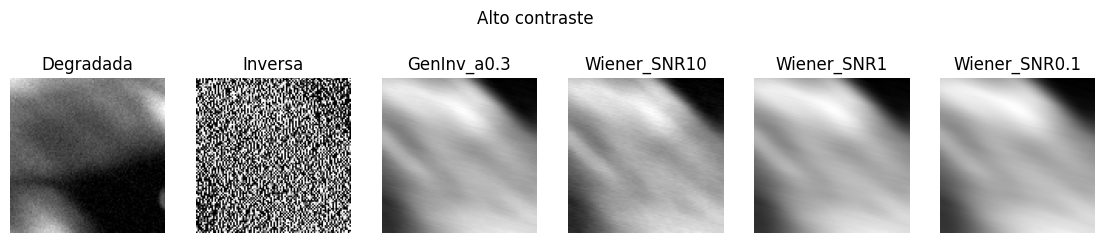

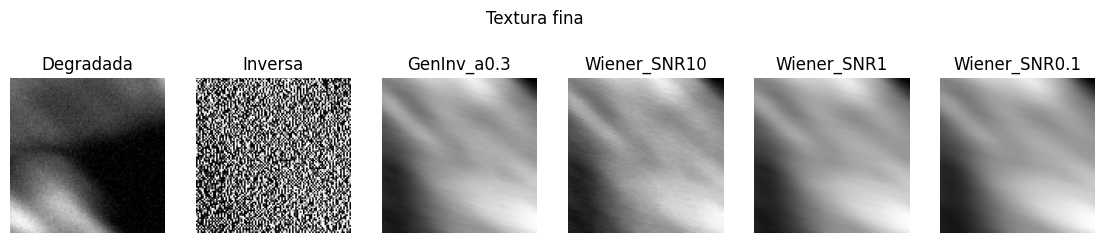

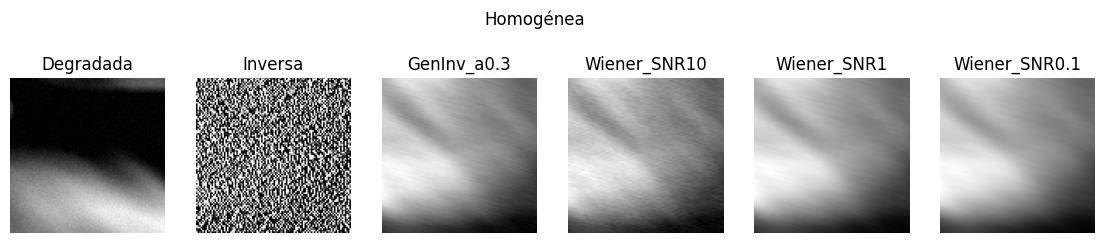

In [8]:
h,w = img.shape

rcs = {
    'Alto contraste': (h//4, w//4, 100, 100),
    'Textura fina': (h//2-50, w//2-100, 100, 100),
    'Homogénea': (h-150, w-150, 100, 100)
}

for title, (y0, x0, hh, ww) in rcs.items():
    y1, x1, y2, x2 = y0, x0, y0+hh, x0+ww
    plt.figure(figsize=(14,3))
    plt.suptitle(title)
    i = 1
    for name, rec in candidates.items():
        plt.subplot(1, len(candidates), i)
        plt.title(name)
        plt.imshow(rec[y1:y2, x1:x2], cmap='gray')
        plt.axis('off')
        i += 1
